# Keypoint(Patch) Description
  
This project will be all about defining and training a convolutional neural network to perform keypoint  description. 
PyTorch tutorials are available at: https://github.com/yunjey/pytorch-tutorial


The first step is to load and visualize the data you'll be working with. 

We will use below dataset in this project:
###  The Photo Tourism dataset 
(http://phototour.cs.washington.edu/patches/default.htm)

It is also available in PyTorch torchvision datasets:
https://pytorch.org/docs/stable/_modules/torchvision/datasets/phototour.html#PhotoTour

This dataset consists of 1024 x 1024 bitmap (.bmp) images, each containing a 16 x 16 array of image patches. Here are some examples:

<table><tr><td><img src='images/patches0001.bmp'></td><td><img src='images/patches1482.bmp'></td></tr></table>    
For details of how the scale and orientation is established, please see the paper:  
<p class="style8"><font size="2">S. Winder and M. Brown. <strong>Learning Local Image 
				Descriptors</strong>. To appear <i>International Conference on 
				Computer Vision and Pattern Recognition (CVPR2007)</i> (</font><a href="http://research.microsoft.com/~swinder/papers/winder_brown_cvpr07.pdf"><span class="style9">pdf 
				300Kb</span></a><font size="2">)</font></p>



---

### Import packages

In [1]:
from __future__ import division, print_function
import glob
import os
import cv2
import PIL
import random
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
import torch.nn.init
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
import torchvision.datasets as dset
import torchvision.transforms as transforms
from tqdm import tqdm
from torch.autograd import Variable
from copy import deepcopy, copy
from config_profile import args
from Utils import cv2_scale36, cv2_scale, np_reshape, np_reshape64

### Check GPU availability, using nvidia-smi 

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

### Define PyTorch dataset

In [3]:
class TripletPhotoTour(dset.PhotoTour):
    """
    From the PhotoTour Dataset it generates triplet samples
    note: a triplet is composed by a pair of matching images and one of
    different class.
    """
    def __init__(self, train=True, transform=None, batch_size = None,load_random_triplets = False,  *arg, **kw):
        super(TripletPhotoTour, self).__init__(*arg, **kw)
        self.transform = transform
        self.out_triplets = load_random_triplets
        self.train = train
        self.n_triplets = args.n_triplets
        self.batch_size = batch_size

        if self.train:
            print('Generating {} triplets'.format(self.n_triplets))
            self.triplets = self.generate_triplets(self.labels, self.n_triplets)

    @staticmethod
    def generate_triplets(labels, num_triplets):
        def create_indices(_labels):
            inds = dict()
            for idx, ind in enumerate(_labels):
                if ind not in inds:
                    inds[ind] = []
                inds[ind].append(idx)
            return inds

        triplets = []
        indices = create_indices(labels.numpy())
        unique_labels = np.unique(labels.numpy())
        n_classes = unique_labels.shape[0]
        # add only unique indices in batch
        already_idxs = set()

        for x in tqdm(range(num_triplets)):
            if len(already_idxs) >= args.batch_size:
                already_idxs = set()
            c1 = np.random.randint(0, n_classes)
            while c1 in already_idxs:
                c1 = np.random.randint(0, n_classes)
            already_idxs.add(c1)
            c2 = np.random.randint(0, n_classes)
            while c1 == c2:
                c2 = np.random.randint(0, n_classes)
            if len(indices[c1]) == 2:  # hack to speed up process
                n1, n2 = 0, 1
            else:
                n1 = np.random.randint(0, len(indices[c1]))
                n2 = np.random.randint(0, len(indices[c1]))
                while n1 == n2:
                    n2 = np.random.randint(0, len(indices[c1]))
            n3 = np.random.randint(0, len(indices[c2]))
            triplets.append([indices[c1][n1], indices[c1][n2], indices[c2][n3]])
        return torch.LongTensor(np.array(triplets))

    def __getitem__(self, index):
        def transform_img(img):
            if self.transform is not None:
                img = self.transform(img.numpy())
            return img

        if not self.train:
            m = self.matches[index]
            img1 = transform_img(self.data[m[0]])
            img2 = transform_img(self.data[m[1]])
            return img1, img2, m[2]

        t = self.triplets[index]
        a, p, n = self.data[t[0]], self.data[t[1]], self.data[t[2]]

        img_a = transform_img(a)
        img_p = transform_img(p)
        img_n = None
        if self.out_triplets:
            img_n = transform_img(n)
        # transform images if required
        if args.fliprot:
            do_flip = random.random() > 0.5
            do_rot = random.random() > 0.5
            if do_rot:
                img_a = img_a.permute(0,2,1)
                img_p = img_p.permute(0,2,1)
                if self.out_triplets:
                    img_n = img_n.permute(0,2,1)
            if do_flip:
                img_a = torch.from_numpy(deepcopy(img_a.numpy()[:,:,::-1]))
                img_p = torch.from_numpy(deepcopy(img_p.numpy()[:,:,::-1]))
                if self.out_triplets:
                    img_n = torch.from_numpy(deepcopy(img_n.numpy()[:,:,::-1]))
        if self.out_triplets:
            return (img_a, img_p, img_n)
        else:
            return (img_a, img_p)

    def __len__(self):
        if self.train:
            return self.triplets.size(0)
        else:
            return self.matches.size(0)

### Define the dataloader

In [4]:
def create_loaders(dataset_names, load_random_triplets = False):
    test_dataset_names = copy(dataset_names)
    test_dataset_names.remove(args.training_set)

    kwargs = {'num_workers': args.num_workers, 'pin_memory': args.pin_memory} if args.cuda else {}

    np_reshape64 = lambda x: np.reshape(x, (64, 64, 1))
    transform_test = transforms.Compose([
            transforms.Lambda(np_reshape64),
            transforms.ToPILImage(),
            transforms.Resize(32),
            transforms.ToTensor()])
    transform_train = transforms.Compose([
            transforms.Lambda(np_reshape64),
            transforms.ToPILImage(),
            transforms.RandomRotation(5,PIL.Image.BILINEAR),
            transforms.RandomResizedCrop(32, scale = (0.9,1.0),ratio = (0.9,1.1)),
            transforms.Resize(32),
            transforms.ToTensor()])
    transform = transforms.Compose([
            transforms.Lambda(cv2_scale),
            transforms.Lambda(np_reshape),
            transforms.ToTensor(),
            transforms.Normalize((args.mean_image,), (args.std_image,))])
    if not args.augmentation:
        transform_train = transform
        transform_test = transform
    train_loader = torch.utils.data.DataLoader(
            TripletPhotoTour(train=True,
                             load_random_triplets = load_random_triplets,
                             batch_size=args.batch_size,
                             root=args.dataroot,
                             name=args.training_set,
                             download=True,
                             transform=transform_train),
                             batch_size=args.batch_size,
                             shuffle=True, **kwargs)

    test_loaders = [{'name': name,
                     'dataloader': torch.utils.data.DataLoader(
             TripletPhotoTour(train=False,
                     batch_size=args.test_batch_size,
                     root=args.dataroot,
                     name=name,
                     download=True,
                     transform=transform_test),
                        batch_size=args.test_batch_size,
                        shuffle=False, **kwargs)}
                    for name in test_dataset_names]

    return train_loader, test_loaders

### Load Data

Load the Photo Tourism dataset by PyTorch. Below line (function 'create_loader') will help you to download the dataset to your directory. The data dir and other configuration setings are specified in config_profile.py.


In [5]:
dataset_names = ['liberty', 'notredame', 'yosemite']
train_loader, test_loaders = create_loaders(dataset_names, load_random_triplets = args.load_random_triplets)

# Found cached data data/sets/liberty.pt


  0%|          | 0/100000 [00:00<?, ?it/s]

Generating 100000 triplets


100%|██████████| 100000/100000 [00:01<00:00, 93393.92it/s]


# Found cached data data/sets/notredame.pt
# Found cached data data/sets/yosemite.pt


---
##  Visualizaiton of the Training and Testing Data
Below are some examples of patches in this dataset.

#### Training
In the training phase, the input data is a batch of patch pairs: X = {(patch_a, patch_p)}, which represents the anchor patch and the positive patch, respectively. 

---

IN TRAINing, each data entry has 2 elements, each with size of: 
torch.Size([1024, 1, 32, 32])
Below two rows images are 3 examples for patch_a and patch_p


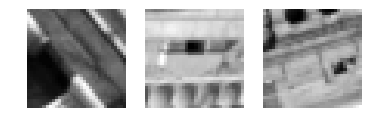

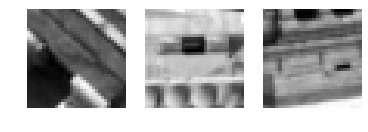

In [6]:
nrow = 3  
def plot_examples(img_tensor, nrow):  
    fig, axs = plt.subplots(1, nrow)
    for i, ax in enumerate(axs):
        img = img_tensor[i, 0]
        ax.imshow(img, cmap='gray')
        ax.axis('off')

for i_batch, sample_batched in enumerate(train_loader):
    print("IN TRAINing, each data entry has {} elements, each with size of: ".format(len(sample_batched)))
    print(sample_batched[0].shape)
    print("Below two rows images are {} examples for patch_a and patch_p".format(nrow))
    if i_batch == 0:
        plot_examples(sample_batched[0], nrow)
        plot_examples(sample_batched[1], nrow)
        plt.show()
        break

#### Testing
In the testing phase, the input data is a batch of patch pairs, and a label that indicates the matching result of this pair (1 means match and 0 means not match)

IN TESTING, each data entry has 3 elements, with size of: torch.Size([1024, 1, 32, 32]), torch.Size([1024, 1, 32, 32]), and torch.Size([1024])

Below two rows images are 3 examples for for patch_a and patch_p.
labels are : tensor([0, 0, 1])


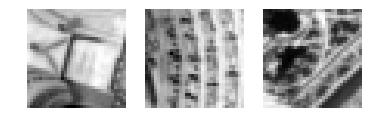

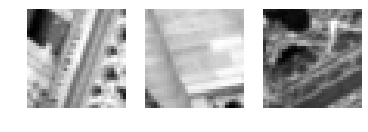

In [7]:
for i_batch, sample_batched in enumerate(test_loaders[0]['dataloader']):
    print("IN TESTING, each data entry has {} elements, with size of: {}, {}, and {}".format(len(sample_batched), 
                                                                                             sample_batched[0].shape, 
                                                                                             sample_batched[1].shape, 
                                                                                             sample_batched[2].shape))
    print("\nBelow two rows images are {} examples for for patch_a and patch_p.".format(nrow))
    if i_batch == 0:
        plot_examples(sample_batched[0], nrow)
        plot_examples(sample_batched[1], nrow)
        print("labels are :", sample_batched[2][:nrow])
        plt.show()
        break

---
### Build Network Model
The DesNet is a simple CNN network, which only contains two CNN blocks.

In [8]:
# load network
from descriptor import DesNet
from descriptor2 import DesNet_2
from descriptor3 import DesNet_3
#model = DesNet()
model1 = DesNet()
model2 = DesNet_2()
model3 = DesNet_3()

model = model2;
outputs = []
accuracylistnotredame = []
accuracylistyosemite = []

if args.cuda:
        model.cuda()
        model1.cuda()
        model2.cuda()
        model3.cuda()


/scratch/massonm/CNN_keypoints_description/descriptor.py:58: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  nn.init.constant(m.bias.data, 0.01)
/scratch/massonm/CNN_keypoints_description/descriptor2.py:64: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  nn.init.constant(m.bias.data, 0.01)
/scratch/massonm/CNN_keypoints_description/descriptor3.py:70: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  nn.init.constant(m.bias.data, 0.01)


### Define optimize
We will use SGD, but you can change it to ADAM by modifying arg.lr in config_profile.py

In [9]:
# define optimizer
def create_optimizer(model, new_lr):
    # setup optimizer
    if args.optimizer == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=new_lr,
                              momentum=0.9, dampening=0.9,
                              weight_decay=args.wd)
    elif args.optimizer == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=new_lr,
                               weight_decay=args.wd)
    else:
        raise Exception('Not supported optimizer: {0}'.format(args.optimizer))
    return optimizer
optimizer1 = create_optimizer(model.features, args.lr)

### Define a training module

In [10]:
def train(train_loader, model, optimizer, epoch, logger, load_triplets  = False):
    # switch to train mode
    model.train()
    pbar = tqdm(enumerate(train_loader))
    for batch_idx, data in pbar:
        if load_triplets:
            data_a, data_p, data_n = data
        else:
            data_a, data_p = data

        if args.cuda:
            data_a, data_p  = data_a.cuda(), data_p.cuda()
            data_a, data_p = Variable(data_a), Variable(data_p)
            out_a = model(data_a)
            out_p = model(data_p)
        if load_triplets:
            data_n  = data_n.cuda()
            data_n = Variable(data_n)
            out_n = model(data_n)
        
        
        loss = loss_DesNet(out_a, out_p,
                        margin=args.margin,
                        anchor_swap=args.anchorswap,
                        anchor_ave=args.anchorave,
                        batch_reduce = args.batch_reduce,
                        loss_type = args.loss)

        if args.decor:
            loss += CorrelationPenaltyLoss()(out_a)
            
        if args.gor:
            loss += args.alpha*global_orthogonal_regularization(out_a, out_n)
            
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        adjust_learning_rate(optimizer)
        if batch_idx % args.log_interval == 0:
            pbar.set_description(
                'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data_a), len(train_loader.dataset),
                           100. * batch_idx / len(train_loader),
                    loss.item()))


    if (args.enable_logging):
#         logger.log_value('loss', loss.data[0]).step()
        logger.log_value('loss', loss.item()).step()

    try:
        os.stat('{}{}'.format(args.model_dir,suffix))
    except:
        os.makedirs('{}{}'.format(args.model_dir,suffix))

    torch.save({'epoch': epoch + 1, 'state_dict': model.state_dict()},
               '{}{}/checkpoint_{}.pth'.format(args.model_dir,suffix,epoch))
        
    outputs.append(loss.item())

    
def adjust_learning_rate(optimizer):
    """Updates the learning rate given the learning rate decay.
    The routine has been implemented according to the original Lua SGD optimizer
    """
    for group in optimizer.param_groups:
        if 'step' not in group:
            group['step'] = 0.
        else:
            group['step'] += 1.
        group['lr'] = args.lr * (
        1.0 - float(group['step']) * float(args.batch_size) / (args.n_triplets * float(args.epochs)))
    return

### Define a test module

In [11]:
def test(test_loader, model, epoch, logger, logger_test_name):
    # switch to evaluate mode
    model.eval()

    labels, distances = [], []

    pbar = tqdm(enumerate(test_loader))
    for batch_idx, (data_a, data_p, label) in pbar:
        # data_a.shape= torch.Size([1024, 1, 32, 32]) 
        # data_p.shape =torch.Size([1024, 1, 32, 32]) 
        # label.shape = torch.Size([1024])
        if args.cuda:
            data_a, data_p = data_a.cuda(), data_p.cuda()

        data_a, data_p, label = Variable(data_a, volatile=True), \
                                Variable(data_p, volatile=True), Variable(label)
        out_a = model(data_a)
        out_p = model(data_p)
        dists = torch.sqrt(torch.sum((out_a - out_p) ** 2, 1))  # euclidean distance
        distances.append(dists.data.cpu().numpy().reshape(-1,1))
        ll = label.data.cpu().numpy().reshape(-1, 1)
        labels.append(ll)

        if batch_idx % args.log_interval == 0:
            pbar.set_description(logger_test_name+' Test Epoch: {} [{}/{} ({:.0f}%)]'.format(
                epoch, batch_idx * len(data_a), len(test_loader.dataset),
                       100. * batch_idx / len(test_loader)))

    num_tests = test_loader.dataset.matches.size(0)
    labels = np.vstack(labels).reshape(num_tests)
    distances = np.vstack (distances).reshape(num_tests)

    fpr95 = ErrorRateAt95Recall(labels, 1.0 / (distances + 1e-8))
    print('\33[91mTest set: Accuracy(FPR95): {:.8f}\n\33[0m'.format(fpr95))
    if logger_test_name == "yosemite":
        accuracylistyosemite.append(fpr95)
    if logger_test_name == "notredame":
        accuracylistnotredame.append(fpr95)

    if (args.enable_logging):
        logger.log_value(logger_test_name+' fpr95', fpr95)
    return


def ErrorRateAt95Recall(labels, scores):
    distances = 1.0 / (scores + 1e-8)
    recall_point = 0.95
    labels = labels[np.argsort(distances)]
    # Sliding threshold: get first index where recall >= recall_point. 
    # This is the index where the number of elements with label==1 below the threshold reaches a fraction of 
    # 'recall_point' of the total number of elements with label==1. 
    # (np.argmax returns the first occurrence of a '1' in a bool array). 
    threshold_index = np.argmax(np.cumsum(labels) >= recall_point * np.sum(labels)) 

    FP = np.sum(labels[:threshold_index] == 0) # Below threshold (i.e., labelled positive), but should be negative
    TN = np.sum(labels[threshold_index:] == 0) # Above threshold (i.e., labelled negative), and should be negative
    return float(FP) / float(FP + TN)

### Training 

In [13]:
start = args.start_epoch
end = start + args.epochs
logger, file_logger = None, None
triplet_flag = args.load_random_triplets
from Losses import loss_DesNet
TEST_ON_W1BS = True
LOG_DIR = args.log_dir
if(args.enable_logging):
    from Loggers import Logger, FileLogger
    logger = Logger(LOG_DIR)
    
suffix = '{}_{}_{}'.format(args.experiment_name, args.training_set, args.batch_reduce)
if args.gor:
    suffix = suffix+'_gor_alpha{:1.1f}'.format(args.alpha)
if args.anchorswap:
    suffix = suffix + '_as'
if args.anchorave:
    suffix = suffix + '_av'
if args.fliprot:
        suffix = suffix + '_fliprot'

res_fpr_liberty = torch.zeros(end-start,1)
res_fpr_notredame = torch.zeros(end-start, 1)
res_fpr_yosemite = torch.zeros(end-start, 1)

epochlist = []

for epoch in range(start, end):

    # iterate over test loaders and test results
    train(train_loader, model, optimizer1, epoch, logger, triplet_flag)
    for test_loader in test_loaders:
        test(test_loader['dataloader'], model, epoch, logger, test_loader['name'])

    #randomize train loader batches
    train_loader, test_loaders2 = create_loaders(args.dataset_names, load_random_triplets=triplet_flag)
    epochlist.append(epoch)

fname = 'output.csv'
with open(fname, 'w', newline='') as f:
    writer = csv.writer(f)
    for row_index in range(len(outputs)):
        row = [epochlist[row_index], outputs[row_index]]
        writer.writerow(row)
        
fname = 'accuracynotredame.csv'
with open(fname, 'w', newline='') as f:
    writer = csv.writer(f)
    for row_index in range(len(accuracylistnotredame)):
        row = [epochlist[row_index], accuracylistnotredame[row_index]]
        writer.writerow(row)
        
fname = 'accuracyyosemite.csv'
with open(fname, 'w', newline='') as f:
    writer = csv.writer(f)
    for row_index in range(len(accuracylistnotredame)):
        row = [epochlist[row_index], accuracylistyosemite[row_index]]
        writer.writerow(row)



Train Epoch: 0 [92160/100000 (92%)]	Loss: 1.240041: : 98it [00:28,  3.77it/s]
0it [00:00, ?it/s]/nfs/stak/users/massonm/miniconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  from ipykernel import kernelapp as app
/nfs/stak/users/massonm/miniconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  app.launch_new_instance()
notredame Test Epoch: 0 [92160/100000 (92%)]: : 98it [00:19,  5.54it/s]
0it [00:00, ?it/s]

Test set: Accuracy(FPR95): 0.71098000



yosemite Test Epoch: 0 [92160/100000 (92%)]: : 98it [00:20,  5.28it/s]


Test set: Accuracy(FPR95): 0.69756000

# Found cached data data/sets/liberty.pt
Generating 100000 triplets

100%|██████████| 100000/100000 [00:00<00:00, 102981.96it/s]



# Found cached data data/sets/notredame.pt
# Found cached data data/sets/yosemite.pt


Train Epoch: 1 [92160/100000 (92%)]	Loss: 1.579254: : 98it [00:29,  3.72it/s]
notredame Test Epoch: 1 [92160/100000 (92%)]: : 98it [00:19,  4.98it/s]
yosemite Test Epoch: 1 [0/100000 (0%)]: : 1it [00:00,  5.10it/s]

Test set: Accuracy(FPR95): 0.73844000



yosemite Test Epoch: 1 [92160/100000 (92%)]: : 98it [00:19,  5.46it/s]


Test set: Accuracy(FPR95): 0.72984000

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:00<00:00, 107533.66it/s]


Generating 100000 triplets
# Found cached data data/sets/notredame.pt
# Found cached data data/sets/yosemite.pt


Train Epoch: 2 [92160/100000 (92%)]	Loss: 2.067830: : 98it [00:30,  3.56it/s]
notredame Test Epoch: 2 [92160/100000 (92%)]: : 98it [00:20,  5.48it/s]
yosemite Test Epoch: 2 [0/100000 (0%)]: : 1it [00:00,  5.08it/s]

Test set: Accuracy(FPR95): 0.94538000



yosemite Test Epoch: 2 [92160/100000 (92%)]: : 98it [00:20,  5.49it/s]


Test set: Accuracy(FPR95): 0.94688000

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:01<00:00, 87751.66it/s]


Generating 100000 triplets
# Found cached data data/sets/notredame.pt
# Found cached data data/sets/yosemite.pt


Train Epoch: 3 [92160/100000 (92%)]	Loss: 2.207462: : 98it [00:29,  3.64it/s]
notredame Test Epoch: 3 [92160/100000 (92%)]: : 98it [00:19,  5.42it/s]
yosemite Test Epoch: 3 [0/100000 (0%)]: : 1it [00:00,  5.06it/s]

Test set: Accuracy(FPR95): 0.95236000



yosemite Test Epoch: 3 [92160/100000 (92%)]: : 98it [00:19,  5.72it/s]


Test set: Accuracy(FPR95): 0.94780000

# Found cached data data/sets/liberty.pt
Generating 100000 triplets


100%|██████████| 100000/100000 [00:00<00:00, 106276.44it/s]


# Found cached data data/sets/notredame.pt
# Found cached data data/sets/yosemite.pt


Train Epoch: 4 [92160/100000 (92%)]	Loss: 2.227774: : 98it [00:29,  3.88it/s]
notredame Test Epoch: 4 [92160/100000 (92%)]: : 98it [00:19,  5.64it/s]
yosemite Test Epoch: 4 [0/100000 (0%)]: : 1it [00:00,  5.15it/s]

Test set: Accuracy(FPR95): 0.95234000



yosemite Test Epoch: 4 [92160/100000 (92%)]: : 98it [00:19,  5.43it/s]


Test set: Accuracy(FPR95): 0.95030000

# Found cached data data/sets/liberty.pt
Generating 100000 triplets

100%|██████████| 100000/100000 [00:01<00:00, 89524.74it/s]



# Found cached data data/sets/notredame.pt
# Found cached data data/sets/yosemite.pt

Train Epoch: 5 [92160/100000 (92%)]	Loss: 2.235125: : 98it [00:28,  3.80it/s]
notredame Test Epoch: 5 [92160/100000 (92%)]: : 98it [00:19,  5.57it/s]
0it [00:00, ?it/s]


Test set: Accuracy(FPR95): 0.94284000



yosemite Test Epoch: 5 [92160/100000 (92%)]: : 98it [00:19,  5.51it/s]


Test set: Accuracy(FPR95): 0.94978000

# Found cached data data/sets/liberty.pt
Generating 100000 triplets

100%|██████████| 100000/100000 [00:00<00:00, 112295.28it/s]



# Found cached data data/sets/notredame.pt
# Found cached data data/sets/yosemite.pt


Train Epoch: 6 [92160/100000 (92%)]	Loss: 2.260725: : 98it [00:29,  3.69it/s]
notredame Test Epoch: 6 [92160/100000 (92%)]: : 98it [00:19,  5.62it/s]
0it [00:00, ?it/s]

Test set: Accuracy(FPR95): 0.95390000



yosemite Test Epoch: 6 [92160/100000 (92%)]: : 98it [00:19,  5.14it/s]


Test set: Accuracy(FPR95): 0.95024000

# Found cached data data/sets/liberty.pt
Generating 100000 triplets


100%|██████████| 100000/100000 [00:00<00:00, 105583.09it/s]


# Found cached data data/sets/notredame.pt
# Found cached data data/sets/yosemite.pt


Train Epoch: 7 [92160/100000 (92%)]	Loss: 2.259168: : 98it [00:28,  3.82it/s]
notredame Test Epoch: 7 [92160/100000 (92%)]: : 98it [00:19,  5.20it/s]
0it [00:00, ?it/s]

Test set: Accuracy(FPR95): 0.95404000



yosemite Test Epoch: 7 [92160/100000 (92%)]: : 98it [00:20,  5.47it/s]


Test set: Accuracy(FPR95): 0.95112000

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:00<00:00, 107959.08it/s]


Generating 100000 triplets
# Found cached data data/sets/notredame.pt
# Found cached data data/sets/yosemite.pt


Train Epoch: 8 [92160/100000 (92%)]	Loss: 2.255136: : 98it [00:28,  3.70it/s]
notredame Test Epoch: 8 [92160/100000 (92%)]: : 98it [00:19,  5.67it/s]
0it [00:00, ?it/s]

Test set: Accuracy(FPR95): 0.95694000



yosemite Test Epoch: 8 [92160/100000 (92%)]: : 98it [00:20,  5.36it/s]


Test set: Accuracy(FPR95): 0.95126000

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:00<00:00, 104028.60it/s]


Generating 100000 triplets
# Found cached data data/sets/notredame.pt
# Found cached data data/sets/yosemite.pt


Train Epoch: 9 [92160/100000 (92%)]	Loss: 2.262337: : 98it [00:30,  3.71it/s]
notredame Test Epoch: 9 [92160/100000 (92%)]: : 98it [00:19,  5.45it/s]
0it [00:00, ?it/s]

Test set: Accuracy(FPR95): 0.95716000



yosemite Test Epoch: 9 [92160/100000 (92%)]: : 98it [00:19,  5.56it/s]


Test set: Accuracy(FPR95): 0.95316000

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:00<00:00, 103615.46it/s]


Generating 100000 triplets
# Found cached data data/sets/notredame.pt
# Found cached data data/sets/yosemite.pt


Train Epoch: 10 [92160/100000 (92%)]	Loss: 2.280265: : 98it [00:28,  3.86it/s]
notredame Test Epoch: 10 [92160/100000 (92%)]: : 98it [00:20,  5.58it/s]
0it [00:00, ?it/s]

Test set: Accuracy(FPR95): 0.95460000



yosemite Test Epoch: 10 [92160/100000 (92%)]: : 98it [00:19,  5.56it/s]


Test set: Accuracy(FPR95): 0.95458000

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:00<00:00, 109967.46it/s]


Generating 100000 triplets
# Found cached data data/sets/notredame.pt
# Found cached data data/sets/yosemite.pt


Train Epoch: 11 [92160/100000 (92%)]	Loss: 2.261451: : 98it [00:29,  3.74it/s]
notredame Test Epoch: 11 [92160/100000 (92%)]: : 98it [00:19,  5.54it/s]
0it [00:00, ?it/s]

Test set: Accuracy(FPR95): 0.95594000



yosemite Test Epoch: 11 [92160/100000 (92%)]: : 98it [00:19,  5.62it/s]


Test set: Accuracy(FPR95): 0.95402000

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:00<00:00, 100625.71it/s]


Generating 100000 triplets
# Found cached data data/sets/notredame.pt
# Found cached data data/sets/yosemite.pt

Train Epoch: 12 [92160/100000 (92%)]	Loss: 2.260555: : 98it [00:29,  3.70it/s]
notredame Test Epoch: 12 [92160/100000 (92%)]: : 98it [00:19,  5.37it/s]
0it [00:00, ?it/s]


Test set: Accuracy(FPR95): 0.95572000



yosemite Test Epoch: 12 [92160/100000 (92%)]: : 98it [00:19,  5.57it/s]


Test set: Accuracy(FPR95): 0.95560000

# Found cached data data/sets/liberty.pt
Generating 100000 triplets


100%|██████████| 100000/100000 [00:00<00:00, 110550.98it/s]


# Found cached data data/sets/notredame.pt
# Found cached data data/sets/yosemite.pt


Train Epoch: 13 [92160/100000 (92%)]	Loss: 2.256412: : 98it [00:29,  3.74it/s]
notredame Test Epoch: 13 [92160/100000 (92%)]: : 98it [00:19,  5.12it/s]
yosemite Test Epoch: 13 [0/100000 (0%)]: : 1it [00:00,  5.06it/s]

Test set: Accuracy(FPR95): 0.95970000



yosemite Test Epoch: 13 [92160/100000 (92%)]: : 98it [00:20,  5.54it/s]


Test set: Accuracy(FPR95): 0.95602000

# Found cached data data/sets/liberty.pt
Generating 100000 triplets

100%|██████████| 100000/100000 [00:00<00:00, 103843.70it/s]



# Found cached data data/sets/notredame.pt


Train Epoch: 14 [92160/100000 (92%)]	Loss: 2.242489: : 98it [00:28,  3.73it/s]
notredame Test Epoch: 14 [92160/100000 (92%)]: : 98it [00:19,  5.59it/s]
0it [00:00, ?it/s]

# Found cached data data/sets/yosemite.pt
Test set: Accuracy(FPR95): 0.95922000



yosemite Test Epoch: 14 [92160/100000 (92%)]: : 98it [00:19,  5.27it/s]


Test set: Accuracy(FPR95): 0.95718000

# Found cached data data/sets/liberty.pt
Generating 100000 triplets


100%|██████████| 100000/100000 [00:00<00:00, 110335.45it/s]


# Found cached data data/sets/notredame.pt
# Found cached data data/sets/yosemite.pt


Train Epoch: 15 [92160/100000 (92%)]	Loss: 2.282881: : 98it [00:29,  3.74it/s]
notredame Test Epoch: 15 [92160/100000 (92%)]: : 98it [00:19,  5.65it/s]
yosemite Test Epoch: 15 [0/100000 (0%)]: : 1it [00:00,  5.05it/s]

Test set: Accuracy(FPR95): 0.95498000



yosemite Test Epoch: 15 [92160/100000 (92%)]: : 98it [00:19,  5.51it/s]


Test set: Accuracy(FPR95): 0.95192000

# Found cached data data/sets/liberty.pt
Generating 100000 triplets

100%|██████████| 100000/100000 [00:00<00:00, 109616.52it/s]



# Found cached data data/sets/notredame.pt
# Found cached data data/sets/yosemite.pt


Train Epoch: 16 [92160/100000 (92%)]	Loss: 2.259184: : 98it [00:29,  3.69it/s]
notredame Test Epoch: 16 [92160/100000 (92%)]: : 98it [00:19,  5.54it/s]
yosemite Test Epoch: 16 [0/100000 (0%)]: : 1it [00:00,  5.17it/s]

Test set: Accuracy(FPR95): 0.94906000



yosemite Test Epoch: 16 [92160/100000 (92%)]: : 98it [00:19,  5.46it/s]


Test set: Accuracy(FPR95): 0.94978000

# Found cached data data/sets/liberty.pt
Generating 100000 triplets


100%|██████████| 100000/100000 [00:01<00:00, 96072.40it/s]


# Found cached data data/sets/notredame.pt
# Found cached data data/sets/yosemite.pt


Train Epoch: 17 [92160/100000 (92%)]	Loss: 2.267726: : 98it [00:29,  3.62it/s]
notredame Test Epoch: 17 [92160/100000 (92%)]: : 98it [00:19,  5.48it/s]
yosemite Test Epoch: 17 [0/100000 (0%)]: : 1it [00:00,  5.03it/s]

Test set: Accuracy(FPR95): 0.94724000



yosemite Test Epoch: 17 [92160/100000 (92%)]: : 98it [00:19,  5.59it/s]


Test set: Accuracy(FPR95): 0.94916000

# Found cached data data/sets/liberty.pt
Generating 100000 triplets

100%|██████████| 100000/100000 [00:01<00:00, 94788.31it/s]



# Found cached data data/sets/notredame.pt
# Found cached data data/sets/yosemite.pt


Train Epoch: 18 [92160/100000 (92%)]	Loss: 2.281481: : 98it [00:29,  3.68it/s]
notredame Test Epoch: 18 [92160/100000 (92%)]: : 98it [00:19,  5.47it/s]
0it [00:00, ?it/s]

Test set: Accuracy(FPR95): 0.95080000



yosemite Test Epoch: 18 [92160/100000 (92%)]: : 98it [00:20,  5.45it/s]


Test set: Accuracy(FPR95): 0.94784000

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:00<00:00, 108870.26it/s]


Generating 100000 triplets
# Found cached data data/sets/notredame.pt
# Found cached data data/sets/yosemite.pt


Train Epoch: 19 [92160/100000 (92%)]	Loss: 2.282043: : 98it [00:28,  3.91it/s]
notredame Test Epoch: 19 [92160/100000 (92%)]: : 98it [00:19,  5.65it/s]
yosemite Test Epoch: 19 [0/100000 (0%)]: : 1it [00:00,  5.19it/s]

Test set: Accuracy(FPR95): 0.95492000



yosemite Test Epoch: 19 [92160/100000 (92%)]: : 98it [00:19,  5.73it/s]


Test set: Accuracy(FPR95): 0.95248000

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:00<00:00, 111492.55it/s]


Generating 100000 triplets
# Found cached data data/sets/notredame.pt
# Found cached data data/sets/yosemite.pt


Train Epoch: 20 [92160/100000 (92%)]	Loss: 2.277505: : 98it [00:29,  3.82it/s]
notredame Test Epoch: 20 [92160/100000 (92%)]: : 98it [00:19,  5.33it/s]
0it [00:00, ?it/s]

Test set: Accuracy(FPR95): 0.94804000



yosemite Test Epoch: 20 [92160/100000 (92%)]: : 98it [00:20,  5.44it/s]


Test set: Accuracy(FPR95): 0.94692000

# Found cached data data/sets/liberty.pt
Generating 100000 triplets


100%|██████████| 100000/100000 [00:00<00:00, 110435.53it/s]


# Found cached data data/sets/notredame.pt


Train Epoch: 21 [92160/100000 (92%)]	Loss: 2.271421: : 98it [00:28,  3.93it/s]
notredame Test Epoch: 21 [92160/100000 (92%)]: : 98it [00:19,  5.52it/s]
yosemite Test Epoch: 21 [0/100000 (0%)]: : 1it [00:00,  5.09it/s]

# Found cached data data/sets/yosemite.pt
Test set: Accuracy(FPR95): 0.94866000



yosemite Test Epoch: 21 [92160/100000 (92%)]: : 98it [00:19,  5.44it/s]


Test set: Accuracy(FPR95): 0.94938000

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:01<00:00, 94151.45it/s]


Generating 100000 triplets
# Found cached data data/sets/notredame.pt
# Found cached data data/sets/yosemite.pt

Train Epoch: 22 [92160/100000 (92%)]	Loss: 2.257240: : 98it [00:30,  3.43it/s]
notredame Test Epoch: 22 [92160/100000 (92%)]: : 98it [00:20,  5.34it/s]
yosemite Test Epoch: 22 [0/100000 (0%)]: : 1it [00:00,  5.10it/s]


Test set: Accuracy(FPR95): 0.95486000



yosemite Test Epoch: 22 [92160/100000 (92%)]: : 98it [00:20,  5.32it/s]


Test set: Accuracy(FPR95): 0.95196000

# Found cached data data/sets/liberty.pt
Generating 100000 triplets

100%|██████████| 100000/100000 [00:00<00:00, 101380.04it/s]



# Found cached data data/sets/notredame.pt
# Found cached data data/sets/yosemite.pt

Train Epoch: 23 [92160/100000 (92%)]	Loss: 2.279095: : 98it [00:29,  3.75it/s]
notredame Test Epoch: 23 [92160/100000 (92%)]: : 98it [00:19,  5.67it/s]
yosemite Test Epoch: 23 [0/100000 (0%)]: : 0it [00:00, ?it/s]


Test set: Accuracy(FPR95): 0.95000000



yosemite Test Epoch: 23 [92160/100000 (92%)]: : 98it [00:19,  5.47it/s]


Test set: Accuracy(FPR95): 0.94828000

# Found cached data data/sets/liberty.pt
Generating 100000 triplets


100%|██████████| 100000/100000 [00:00<00:00, 104707.29it/s]


# Found cached data data/sets/notredame.pt
# Found cached data data/sets/yosemite.pt


Train Epoch: 24 [92160/100000 (92%)]	Loss: 2.298526: : 98it [00:28,  3.68it/s]
notredame Test Epoch: 24 [92160/100000 (92%)]: : 98it [00:19,  5.49it/s]
yosemite Test Epoch: 24 [0/100000 (0%)]: : 1it [00:00,  5.17it/s]

Test set: Accuracy(FPR95): 0.94786000



yosemite Test Epoch: 24 [92160/100000 (92%)]: : 98it [00:19,  5.51it/s]


Test set: Accuracy(FPR95): 0.94772000

# Found cached data data/sets/liberty.pt
Generating 100000 triplets


100%|██████████| 100000/100000 [00:00<00:00, 106162.82it/s]


# Found cached data data/sets/notredame.pt


Train Epoch: 25 [92160/100000 (92%)]	Loss: 2.316547: : 98it [00:28,  3.88it/s]
notredame Test Epoch: 25 [92160/100000 (92%)]: : 98it [00:20,  4.83it/s]
0it [00:00, ?it/s]

# Found cached data data/sets/yosemite.pt
Test set: Accuracy(FPR95): 0.94924000



yosemite Test Epoch: 25 [92160/100000 (92%)]: : 98it [00:20,  5.41it/s]


Test set: Accuracy(FPR95): 0.94804000

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:00<00:00, 105334.26it/s]


Generating 100000 triplets
# Found cached data data/sets/notredame.pt


Train Epoch: 26 [92160/100000 (92%)]	Loss: 2.271375: : 98it [00:30,  3.63it/s]
notredame Test Epoch: 26 [92160/100000 (92%)]: : 98it [00:20,  5.33it/s]
0it [00:00, ?it/s]

# Found cached data data/sets/yosemite.pt
Test set: Accuracy(FPR95): 0.94060000



yosemite Test Epoch: 26 [92160/100000 (92%)]: : 98it [00:20,  5.42it/s]


Test set: Accuracy(FPR95): 0.94316000

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:00<00:00, 108009.73it/s]


Generating 100000 triplets
# Found cached data data/sets/notredame.pt
# Found cached data data/sets/yosemite.pt


Train Epoch: 27 [92160/100000 (92%)]	Loss: 2.297275: : 98it [00:29,  3.71it/s]
notredame Test Epoch: 27 [92160/100000 (92%)]: : 98it [00:19,  5.64it/s]
0it [00:00, ?it/s]

Test set: Accuracy(FPR95): 0.94970000



yosemite Test Epoch: 27 [92160/100000 (92%)]: : 98it [00:19,  5.56it/s]


Test set: Accuracy(FPR95): 0.94468000

# Found cached data data/sets/liberty.pt
Generating 100000 triplets


100%|██████████| 100000/100000 [00:00<00:00, 101730.68it/s]


# Found cached data data/sets/notredame.pt
# Found cached data data/sets/yosemite.pt


Train Epoch: 28 [92160/100000 (92%)]	Loss: 2.272452: : 98it [00:29,  3.68it/s]
notredame Test Epoch: 28 [92160/100000 (92%)]: : 98it [00:19,  5.10it/s]
0it [00:00, ?it/s]

Test set: Accuracy(FPR95): 0.94300000



yosemite Test Epoch: 28 [92160/100000 (92%)]: : 98it [00:19,  5.72it/s]


Test set: Accuracy(FPR95): 0.94388000

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:00<00:00, 112606.11it/s]


Generating 100000 triplets
# Found cached data data/sets/notredame.pt
# Found cached data data/sets/yosemite.pt


Train Epoch: 29 [92160/100000 (92%)]	Loss: 2.305789: : 98it [00:28,  3.67it/s]
notredame Test Epoch: 29 [92160/100000 (92%)]: : 98it [00:19,  5.73it/s]
yosemite Test Epoch: 29 [0/100000 (0%)]: : 1it [00:00,  5.07it/s]

Test set: Accuracy(FPR95): 0.93942000



yosemite Test Epoch: 29 [92160/100000 (92%)]: : 98it [00:19,  5.70it/s]


Test set: Accuracy(FPR95): 0.94120000

# Found cached data data/sets/liberty.pt
Generating 100000 triplets


100%|██████████| 100000/100000 [00:00<00:00, 108332.58it/s]


# Found cached data data/sets/notredame.pt
# Found cached data data/sets/yosemite.pt


Train Epoch: 30 [92160/100000 (92%)]	Loss: 2.269937: : 98it [00:28,  3.76it/s]
notredame Test Epoch: 30 [92160/100000 (92%)]: : 98it [00:19,  5.49it/s]
0it [00:00, ?it/s]

Test set: Accuracy(FPR95): 0.94396000



yosemite Test Epoch: 30 [92160/100000 (92%)]: : 98it [00:19,  5.61it/s]


Test set: Accuracy(FPR95): 0.94408000

# Found cached data data/sets/liberty.pt
Generating 100000 triplets


100%|██████████| 100000/100000 [00:00<00:00, 106563.14it/s]


# Found cached data data/sets/notredame.pt
# Found cached data data/sets/yosemite.pt


Train Epoch: 31 [92160/100000 (92%)]	Loss: 2.293305: : 98it [00:28,  3.66it/s]
notredame Test Epoch: 31 [92160/100000 (92%)]: : 98it [00:19,  5.77it/s]
0it [00:00, ?it/s]

Test set: Accuracy(FPR95): 0.93276000



yosemite Test Epoch: 31 [92160/100000 (92%)]: : 98it [00:20,  5.05it/s]


Test set: Accuracy(FPR95): 0.93712000

# Found cached data data/sets/liberty.pt
Generating 100000 triplets


100%|██████████| 100000/100000 [00:00<00:00, 112335.13it/s]


# Found cached data data/sets/notredame.pt
# Found cached data data/sets/yosemite.pt


Train Epoch: 32 [92160/100000 (92%)]	Loss: 2.300511: : 98it [00:28,  3.64it/s]
notredame Test Epoch: 32 [92160/100000 (92%)]: : 98it [00:19,  5.58it/s]
yosemite Test Epoch: 32 [0/100000 (0%)]: : 1it [00:00,  5.08it/s]

Test set: Accuracy(FPR95): 0.94400000



yosemite Test Epoch: 32 [92160/100000 (92%)]: : 98it [00:19,  5.23it/s]


Test set: Accuracy(FPR95): 0.94046000

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:00<00:00, 110658.31it/s]


Generating 100000 triplets
# Found cached data data/sets/notredame.pt
# Found cached data data/sets/yosemite.pt


Train Epoch: 33 [92160/100000 (92%)]	Loss: 2.305137: : 98it [00:28,  3.74it/s]
notredame Test Epoch: 33 [92160/100000 (92%)]: : 98it [00:19,  5.69it/s]
yosemite Test Epoch: 33 [0/100000 (0%)]: : 0it [00:00, ?it/s]

Test set: Accuracy(FPR95): 0.93912000



yosemite Test Epoch: 33 [92160/100000 (92%)]: : 98it [00:19,  5.59it/s]


Test set: Accuracy(FPR95): 0.94202000

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:00<00:00, 107864.46it/s]


Generating 100000 triplets
# Found cached data data/sets/notredame.pt
# Found cached data data/sets/yosemite.pt


Train Epoch: 34 [92160/100000 (92%)]	Loss: 2.292727: : 98it [00:29,  3.56it/s]
notredame Test Epoch: 34 [92160/100000 (92%)]: : 98it [00:20,  5.51it/s]
0it [00:00, ?it/s]

Test set: Accuracy(FPR95): 0.93900000



yosemite Test Epoch: 34 [92160/100000 (92%)]: : 98it [00:20,  5.27it/s]


Test set: Accuracy(FPR95): 0.93980000

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:00<00:00, 110555.00it/s]


Generating 100000 triplets
# Found cached data data/sets/notredame.pt
# Found cached data data/sets/yosemite.pt


Train Epoch: 35 [92160/100000 (92%)]	Loss: 2.296997: : 98it [00:30,  3.61it/s]
notredame Test Epoch: 35 [92160/100000 (92%)]: : 98it [00:20,  5.38it/s]
0it [00:00, ?it/s]

Test set: Accuracy(FPR95): 0.94194000



yosemite Test Epoch: 35 [92160/100000 (92%)]: : 98it [00:20,  5.30it/s]


Test set: Accuracy(FPR95): 0.94338000

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:00<00:00, 105183.96it/s]


Generating 100000 triplets
# Found cached data data/sets/notredame.pt
# Found cached data data/sets/yosemite.pt


Train Epoch: 36 [92160/100000 (92%)]	Loss: 2.305153: : 98it [00:30,  3.77it/s]
notredame Test Epoch: 36 [92160/100000 (92%)]: : 98it [00:19,  5.52it/s]
0it [00:00, ?it/s]

Test set: Accuracy(FPR95): 0.94270000



yosemite Test Epoch: 36 [92160/100000 (92%)]: : 98it [00:20,  5.17it/s]


Test set: Accuracy(FPR95): 0.94120000

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:00<00:00, 110335.48it/s]


Generating 100000 triplets
# Found cached data data/sets/notredame.pt
# Found cached data data/sets/yosemite.pt


Train Epoch: 37 [92160/100000 (92%)]	Loss: 2.303292: : 98it [00:30,  3.63it/s]
notredame Test Epoch: 37 [92160/100000 (92%)]: : 98it [00:20,  5.46it/s]
0it [00:00, ?it/s]

Test set: Accuracy(FPR95): 0.94064000



yosemite Test Epoch: 37 [92160/100000 (92%)]: : 98it [00:20,  5.19it/s]


Test set: Accuracy(FPR95): 0.94332000

# Found cached data data/sets/liberty.pt
Generating 100000 triplets


100%|██████████| 100000/100000 [00:01<00:00, 93313.44it/s]


# Found cached data data/sets/notredame.pt


Train Epoch: 38 [92160/100000 (92%)]	Loss: 2.286044: : 98it [00:29,  3.55it/s]
notredame Test Epoch: 38 [92160/100000 (92%)]: : 98it [00:20,  5.30it/s]
yosemite Test Epoch: 38 [0/100000 (0%)]: : 1it [00:00,  5.03it/s]

# Found cached data data/sets/yosemite.pt
Test set: Accuracy(FPR95): 0.94252000



yosemite Test Epoch: 38 [92160/100000 (92%)]: : 98it [00:20,  5.40it/s]


Test set: Accuracy(FPR95): 0.94708000

# Found cached data data/sets/liberty.pt
Generating 100000 triplets


100%|██████████| 100000/100000 [00:01<00:00, 95883.48it/s]


# Found cached data data/sets/notredame.pt
# Found cached data data/sets/yosemite.pt

Train Epoch: 39 [92160/100000 (92%)]	Loss: 2.305314: : 98it [00:30,  3.52it/s]
notredame Test Epoch: 39 [92160/100000 (92%)]: : 98it [00:20,  5.41it/s]
yosemite Test Epoch: 39 [0/100000 (0%)]: : 1it [00:00,  5.04it/s]


Test set: Accuracy(FPR95): 0.94394000



yosemite Test Epoch: 39 [92160/100000 (92%)]: : 98it [00:20,  5.33it/s]


Test set: Accuracy(FPR95): 0.94622000

# Found cached data data/sets/liberty.pt
Generating 100000 triplets


100%|██████████| 100000/100000 [00:00<00:00, 107239.36it/s]


# Found cached data data/sets/notredame.pt
# Found cached data data/sets/yosemite.pt


IndexError: list index out of range

In [12]:
### KEYPOINTS DESCRIPTION USING THE TRAINED CNNs

In [13]:
# load patches
patches = torch.load("patches_notredame/patches_notredame.pt")
print(type(patches))
print(patches.shape)
patches = patches.view(-1, 1, 32, 32).cuda()
print(patches.shape)


<class 'torch.Tensor'>
torch.Size([5, 200, 1, 32, 32])
torch.Size([1000, 1, 32, 32])


In [16]:
#################################### weights CNN1 ################################
trained_weight_1 = torch.load("./models/model1_512/_liberty_min_as_fliprot/checkpoint_12.pth")
model1.load_state_dict(trained_weight_1['state_dict'])

output1 = model1(patches)
print(output1.shape)
output1.data.cpu().numpy().shape = torch.Size([1000, 128])
out1 = output1.view(5, 200, 128).cpu().data
#output.data.cpu().numpy().shape = torch.Size([1000, 128])


print(out1.shape)
#output_dir = "CNN1-512-notredame-keypoints-descriptions.pt"
#torch.save(out1, output_dir)

torch.Size([1000, 128])
torch.Size([5, 200, 128])


In [15]:
#################################### weights CNN2 ################################
trained_weight_2 = torch.load("./models/model2_512/_liberty_min_as_fliprot/checkpoint_28.pth")
model2.load_state_dict(trained_weight_2['state_dict'])

output2 = model2(patches)
print(output2.shape)
output2.data.cpu().numpy().shape = torch.Size([1000, 128])
out2 = output2.view(5, 200, 128).cpu().data


print(out2.shape)
#output_dir = "CNN2-512-notredame-keypoints-descriptions.pt"
#torch.save(out2, output_dir)

torch.Size([1000, 128])
torch.Size([5, 200, 128])


In [15]:
#################################### weights CNN3 ################################
trained_weight_3 = torch.load("./models/model3_512/_liberty_min_as_fliprot/checkpoint_39.pth")
model3.load_state_dict(trained_weight_3['state_dict'])

#Forward pass the patches to the model 1
output3 = model3(patches)
print(output3.shape)

output3.data.cpu().numpy().shape = torch.Size([1000, 2048])
#output3.shape = torch.Size([1000, 128])
out3 = output3.view(5, 200, 2048).cpu().data

print(out3.shape)
output_dir = "CNN3-512-notredame-keypoints-descriptions.pt"
torch.save(out3, output_dir)

torch.Size([1000, 2048])
torch.Size([5, 200, 2048])


In [ ]:
#Store themtogether:
all_output = torch.stack((out1, out2, out3))
print(all_output.shape)
output_dir = "../Saeedib_descriptions.pt"
torch.save(all_output, output_dir)
print("Done!")


In [2]:
# load patches
patches = torch.load("patches_notredame/patches_notredame.pt")

patches = patches.view(-1, 1, 32, 32).cuda()

# load network
from descriptor2 import DesNet_2

model2 = DesNet_2()
print(patches.shape)

if args.cuda:
        model2.cuda()
        
output2 = model2(patches)
print(output2.shape)


torch.Size([1000, 1, 32, 32])
torch.Size([1000, 128])


/scratch/massonm/CNN_keypoints_description/descriptor2.py:64: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  nn.init.constant(m.bias.data, 0.01)


In [11]:
import math
padding = 0
K =8
s = 1


math.floor((13+2*padding-(K-1)-1)/s+1)


6